In [12]:
import os, sys, pickle, collections, importlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook

from geopy.distance import geodesic
from sklearn.model_selection import KFold

from keras.layers import Input, Dense, BatchNormalization, Activation
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.models import Model

import utils
importlib.reload(utils)

<module 'utils' from '/Users/williamzhang/Desktop/JHUEP/real_estate_abm/utils.py'>

## Load in the data. What columns are available?

In [13]:
df = pd.read_csv('data.csv')
df = df.loc[df.lat != 0].copy() # unable to geocode all sales
df.reset_index(inplace=True, drop=True)
df.columns

Index(['address', 'year_built', 'sale_price', 'living_area', 'quality', 'day',
       'lat', 'lon'],
      dtype='object')

## Make useful metavars

In [14]:
MIN_LAT = np.floor(df.lat.min() * 10) / 10 # floor by tenths
MAX_LAT = np.ceil(df.lat.max() * 10) / 10  # ceil by tenths
MIN_LON = np.floor(df.lon.min() * 10) / 10 # floor by tenths
MAX_LON = np.ceil(df.lon.max() * 10) / 10  # ceil by tenths
MIN_DAY = df.day.min()
MAX_DAY = df.day.max()

# pt1 -- pt2
#  |
# pt3

pt1 = (MAX_LAT, MIN_LON)
pt2 = (MAX_LAT, MAX_LON)
pt3 = (MIN_LAT, MIN_LON)

print(f'Lat range: {MIN_LAT:.01f} to {MAX_LAT:.01f} --> {geodesic(pt1, pt3).miles:.01f} miles')
print(f'Lon range: {MIN_LON:.01f} to {MAX_LON:.01f} --> {geodesic(pt1, pt2).miles:.01f} miles')

Lat range: 39.1 to 39.4 --> 20.7 miles
Lon range: -77.2 to -76.7 --> 26.8 miles


## Show where all of the sales are

<IPython.core.display.Javascript object>


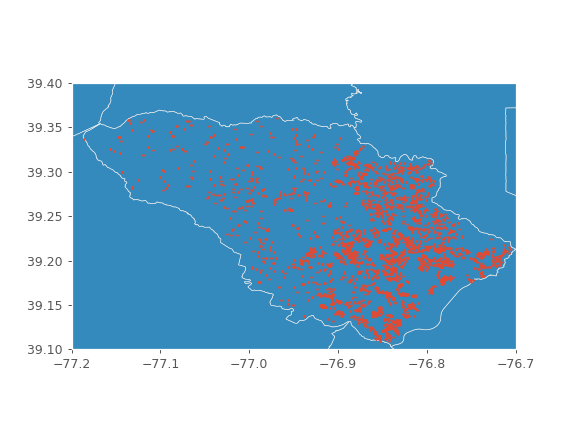

(39.1, 39.4)

In [15]:
borders = gpd.read_file('tl_2016_us_county/tl_2016_us_county.shp')
    
fig, ax = plt.subplots()
borders.plot(ax=ax, edgecolor='#EEEEEE')
ax.scatter(df.lon, df.lat, s=2)
ax.set_xlim([MIN_LON, MAX_LON])
ax.set_ylim([MIN_LAT, MAX_LAT])

## Establish the binning system for the data

In [5]:
LAT_EDGES  = np.linspace(MIN_LAT, MAX_LAT, 12)
LON_EDGES  = np.linspace(MIN_LON, MAX_LON, 15)
TIME_EDGES = np.arange(0, MAX_DAY, 14) # 2 week time periods 

# print out the size of a grid box for debugging
# pt1 -- pt2
#  |
# pt3

pt1 = (LAT_EDGES[-1], LON_EDGES[0])
pt2 = (LAT_EDGES[-1], LON_EDGES[1])
pt3 = (LAT_EDGES[-2], LON_EDGES[0])

print(f'Grid box height --> {geodesic(pt1, pt3).miles:.02f} miles')
print(f'Grid box width --> {geodesic(pt1, pt2).miles:.02f} miles')

Grid box height --> 1.88 miles
Grid box width --> 1.91 miles


In [6]:
# do the binning
df['latbin']  = np.digitize(df.lat, LAT_EDGES) - 1  # 0-indexed bins
df['lonbin']  = np.digitize(df.lon, LON_EDGES) - 1  # 0-indexed bins
df['timebin'] = np.digitize(df.day, TIME_EDGES) - 1 # 0-indexed bins

## Construct a dataset of features --> % change in median price

In [7]:
# The following code is not the most efficient but gets the job done.
# Convention: each row is a sample, each column is a feature.

observed_gridboxes = collections.Counter(zip(df.latbin, df.lonbin, df.timebin))

In [8]:
X, Y = [], []

for gb in observed_gridboxes.keys():
    curr_latbin, curr_lonbin, curr_timebin = gb
    gridbox_sales      = utils.get_bin(df, curr_latbin, curr_lonbin, curr_timebin)
    gridbox_sales_next = utils.get_bin(df, curr_latbin, curr_lonbin, curr_timebin + 1)
    neighbor_sales     = utils.get_neighbors(df, curr_latbin, curr_lonbin, curr_timebin,
                                             size=2, time_history=1)
    
    # TODO - add a global param for minimum required sales (instead of hard-coding 0)
    if len(gridbox_sales) > 0 and len(gridbox_sales_next) > 0 and len(neighbor_sales) > 0:
        stats = np.concatenate((utils.get_stats(neighbor_sales),
                                utils.get_stats(gridbox_sales)))
        future_stats = utils.get_stats(gridbox_sales_next)
        X.append(stats)
        Y.append(future_stats[-2] / stats[-2] - 1) # percent change median sale price

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

(720, 24) (720,)


In [9]:
# scale features and target variables to 0 - 1
x_min = np.min(X, axis=0)
x_max = np.max(X, axis=0)
X     = (X - x_min) / (x_max - x_min)

y_min = np.min(Y)
y_max = np.max(Y)
Y     = (Y - y_min) / (y_max - y_min)

# Train MLP implementation of ABM

In [10]:
def get_untrained_model():
    wd = 1e-3 # weight decay parameter

    inp = Input(shape=(24,))
    lay = Dense(32, kernel_initializer='he_normal', kernel_regularizer=l2(wd))(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dense(48, kernel_initializer='he_normal', kernel_regularizer=l2(wd))(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    out = Dense(1, kernel_initializer='he_normal', kernel_regularizer=l2(wd),
                activation='sigmoid')(lay)

    model = Model(inp, out)
    return model

model = get_untrained_model()
model.summary()





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                1584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48)                192       
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
______

In [11]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
kf.get_n_splits(X)

for train_idx, test_idx in kf.split(X):
    x_train, y_train = X[train_idx], Y[train_idx]
    x_val, y_val     = X[test_idx], Y[test_idx]
    
    model = get_untrained_model()
    model.compile(optimizer=SGD(lr=0.01), loss='mae')
    model.fit(x_train, y_train, batch_size=64, 
              epochs=100, verbose=False)
    print(f'Train MAE = {model.evaluate(x_train, y_train):.04f}')
    print(f'Val MAE = {model.evaluate(x_val, y_val):.04f}')










480/480 [==============================] - 0s 642us/step
Train MAE = 0.1821
240/240 [==============================] - 0s 25us/step
Val MAE = 0.1785
480/480 [==============================] - 0s 744us/step
Train MAE = 0.1829
240/240 [==============================] - 0s 29us/step
Val MAE = 0.1834
480/480 [==============================] - 0s 837us/step
Train MAE = 0.1859
240/240 [==============================] - 0s 27us/step
Val MAE = 0.1909
